In [1]:
import matplotlib.pyplot as plt
from PIL import Image

import torch
import torch.nn.functional as F
from torch import Tensor, nn
from torchvision.transforms import Compose, Resize, ToTensor

import torch
import torchvision
from torchvision import datasets
from torchvision import transforms as T # for simplifying the transforms
from torch import nn, optim
from torch.utils.data import DataLoader, sampler, random_split
from torchvision import models

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import os

import sys
from tqdm import tqdm
import time
import copy

import timm
from timm.loss import LabelSmoothingCrossEntropy # This is better than normal nn.CrossEntropyLoss

# remove warnings
import warnings
warnings.filterwarnings("ignore")

import matplotlib.pyplot as plt
%matplotlib inline

# from torchsummary import summary

/home/sanyam/anaconda3/envs/MGC/lib/python3.8/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
def get_classes(data_dir):
    all_data = datasets.ImageFolder(data_dir)
    return all_data.classes

In [13]:
def get_data_loaders(data_dir, batch_size, train = False):
    if train:
        #train
        transform = T.Compose([
            T.RandomHorizontalFlip(),
            T.RandomVerticalFlip(),
            T.RandomApply(torch.nn.ModuleList([T.ColorJitter()]), p=0.25),
            T.Resize(256),
            T.CenterCrop(224),
            T.ToTensor(),
            T.Normalize((0.485, 0.456, 0.406), (0.229, 0.224, 0.225)), # imagenet means
            T.RandomErasing(p=0.2, value='random')
        ])
        train_data = datasets.ImageFolder(os.path.join(data_dir, "train/images_original/"), transform = transform)
        train_loader = DataLoader(train_data, batch_size=batch_size, shuffle=True, num_workers=4)
        return train_loader, len(train_data)
    else:
        # val/test
        transform = T.Compose([ # We dont need augmentation for test transforms
            T.Resize(256),
            T.CenterCrop(224),
            T.ToTensor(),
            T.Normalize((0.485, 0.456, 0.406), (0.229, 0.224, 0.225)), # imagenet means
        ])
        val_data = datasets.ImageFolder(os.path.join(data_dir, "val/images_original/"), transform=transform)
        test_data = datasets.ImageFolder(os.path.join(data_dir, "test/images_original/"), transform=transform)
        val_loader = DataLoader(val_data, batch_size=batch_size, shuffle=True, num_workers=4)
        test_loader = DataLoader(test_data, batch_size=batch_size, shuffle=True, num_workers=4)
        return val_loader, test_loader, len(val_data), len(test_data)

In [14]:
dataset_path = "../Data"

In [21]:
(train_loader, train_data_len) = get_data_loaders(dataset_path, 32, train=True)
(val_loader, test_loader, valid_data_len, test_data_len) = get_data_loaders(dataset_path, 32, train=False)

In [22]:
print("Train data length: ", train_data_len)
print("Validation data length: ", valid_data_len)

Train data length:  800
Validation data length:  100


In [23]:
classes = get_classes(dataset_path + "/train" + "/images_original")
print(classes, len(classes))

['blues', 'classical', 'country', 'disco', 'hiphop', 'jazz', 'metal', 'pop', 'reggae', 'rock'] 10


In [24]:
dataloaders = {
    "train": train_loader,
    "val": val_loader
}
dataset_sizes = {
    "train": train_data_len,
    "val": valid_data_len
}

In [26]:
print(train_data_len, valid_data_len, test_data_len)

800 100 99


In [27]:
# now, for the model
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device

device(type='cpu')

In [28]:
model = torch.hub.load('facebookresearch/deit:main', 'deit_tiny_patch16_224', pretrained=True)

Using cache found in /home/sanyam/.cache/torch/hub/facebookresearch_deit_main


In [29]:
for param in model.parameters(): #freeze model
    param.requires_grad = False

n_inputs = model.head.in_features
model.head = nn.Sequential(
    nn.Linear(n_inputs, 512),
    nn.ReLU(),
    nn.Dropout(0.3),
    nn.Linear(512, len(classes))
)
model = model.to(device)
print(model.head)

Sequential(
  (0): Linear(in_features=192, out_features=512, bias=True)
  (1): ReLU()
  (2): Dropout(p=0.3, inplace=False)
  (3): Linear(in_features=512, out_features=10, bias=True)
)


In [30]:
criterion = LabelSmoothingCrossEntropy()
criterion = criterion.to(device)
optimizer = optim.Adam(model.head.parameters(), lr=0.001)

In [31]:
# lr scheduler
exp_lr_scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=3, gamma=0.97)

In [42]:
def train_model(model, criterion, optimizer, scheduler, num_epochs=10, checkpoint_path=None, save_path=None, save_interval=10):
    since = time.time()
    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0

    # Load model if checkpoint path is provided
    if checkpoint_path:
        checkpoint = torch.load(checkpoint_path)
        model.load_state_dict(checkpoint['model_state_dict'])
        optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
        best_acc = checkpoint['best_acc']

    # Lists to store metrics
    train_losses, train_accuracies = [], []
    val_losses, val_accuracies = [], []
    
    for epoch in range(num_epochs):
        print(f'Epoch {epoch}/{num_epochs - 1}')
        print("-" * 10)

        for phase in ['train', 'val']:
            if phase == 'train':
                model.train()
            else:
                model.eval()

            running_loss = 0.0
            running_corrects = 0.0

            for inputs, labels in tqdm(dataloaders[phase]):
                inputs = inputs.to(device)
                labels = labels.to(device)

                optimizer.zero_grad()

                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    _, preds = torch.max(outputs, 1)
                    loss = criterion(outputs, labels)

                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)

            if phase == 'train':
                scheduler.step()

            epoch_loss = running_loss / dataset_sizes[phase]
            epoch_acc = running_corrects.double() / dataset_sizes[phase]

            print("{} Loss: {:.4f} Acc: {:.4f}".format(phase, epoch_loss, epoch_acc))

            # Save metrics
            if phase == 'train':
                train_losses.append(epoch_loss)
                train_accuracies.append(epoch_acc)
            else:
                val_losses.append(epoch_loss)
                val_accuracies.append(epoch_acc)

            if phase == 'val' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict())
        if (epoch % save_interval == 0 or epoch == num_epochs - 1) and save_path:
            save_filename = f"{save_path}_epoch_{epoch}.pth"
            torch.save({
                'epoch': epoch,
                'model_state_dict': model.state_dict(),
                'optimizer_state_dict': optimizer.state_dict(),
                'scheduler_state_dict': scheduler.state_dict(),
                'best_acc': best_acc,
                'train_losses': train_losses,
                'train_accuracies': train_accuracies,
                'val_losses': val_losses,
                'val_accuracies': val_accuracies
            }, save_filename)
            print(f"Model saved to {save_filename}")

        print()

    time_elapsed = time.time() - since
    print('Training complete in {:.0f}m {:.0f}s'.format(time_elapsed // 60, time_elapsed % 60))
    print("Best Val Acc: {:.4f}".format(best_acc))

    model.load_state_dict(best_model_wts)

    return model, train_losses, train_accuracies, val_losses, val_accuracies

In [43]:
NUM_EPOCHS = 50
model_ft, train_losses, train_accuracies, val_losses, val_accuracies = train_model(
    model=model,
    criterion=criterion,
    optimizer=optimizer,
    scheduler=exp_lr_scheduler,
    num_epochs=NUM_EPOCHS,
    checkpoint_path=None,
    save_path="../Models/DeiT",
    save_interval=10
)

Epoch 0/49
----------


  0%|          | 0/25 [00:00<?, ?it/s]

100%|██████████| 25/25 [00:11<00:00,  2.10it/s]


train Loss: 0.9784 Acc: 0.8137


100%|██████████| 4/4 [00:01<00:00,  2.27it/s]


val Loss: 1.3110 Acc: 0.6800
Model saved to ../Models/DeiT/_epoch_0.pth

Epoch 1/49
----------


100%|██████████| 25/25 [00:11<00:00,  2.16it/s]


train Loss: 0.9954 Acc: 0.8037


100%|██████████| 4/4 [00:01<00:00,  2.44it/s]


val Loss: 1.3255 Acc: 0.7000

Epoch 2/49
----------


100%|██████████| 25/25 [00:11<00:00,  2.14it/s]


train Loss: 0.9736 Acc: 0.8287


100%|██████████| 4/4 [00:01<00:00,  2.37it/s]


val Loss: 1.3168 Acc: 0.6600

Epoch 3/49
----------


100%|██████████| 25/25 [00:11<00:00,  2.13it/s]


train Loss: 0.9884 Acc: 0.8237


100%|██████████| 4/4 [00:01<00:00,  2.44it/s]


val Loss: 1.3072 Acc: 0.6500

Epoch 4/49
----------


100%|██████████| 25/25 [00:11<00:00,  2.18it/s]


train Loss: 0.9727 Acc: 0.8113


100%|██████████| 4/4 [00:01<00:00,  2.43it/s]


val Loss: 1.2857 Acc: 0.6700

Epoch 5/49
----------


100%|██████████| 25/25 [00:11<00:00,  2.15it/s]


train Loss: 0.9790 Acc: 0.8250


100%|██████████| 4/4 [00:01<00:00,  2.44it/s]


val Loss: 1.2850 Acc: 0.7000

Epoch 6/49
----------


100%|██████████| 25/25 [00:11<00:00,  2.16it/s]


train Loss: 0.9617 Acc: 0.8250


100%|██████████| 4/4 [00:01<00:00,  2.24it/s]


val Loss: 1.2895 Acc: 0.6700

Epoch 7/49
----------


100%|██████████| 25/25 [00:11<00:00,  2.12it/s]


train Loss: 0.9538 Acc: 0.8300


100%|██████████| 4/4 [00:01<00:00,  2.46it/s]


val Loss: 1.2964 Acc: 0.6800

Epoch 8/49
----------


100%|██████████| 25/25 [00:11<00:00,  2.15it/s]


train Loss: 0.9447 Acc: 0.8387


100%|██████████| 4/4 [00:01<00:00,  2.48it/s]


val Loss: 1.3076 Acc: 0.6600

Epoch 9/49
----------


100%|██████████| 25/25 [00:11<00:00,  2.20it/s]


train Loss: 0.9487 Acc: 0.8275


100%|██████████| 4/4 [00:01<00:00,  2.40it/s]


val Loss: 1.2991 Acc: 0.6400

Epoch 10/49
----------


100%|██████████| 25/25 [00:11<00:00,  2.18it/s]


train Loss: 0.9321 Acc: 0.8488


100%|██████████| 4/4 [00:01<00:00,  2.24it/s]


val Loss: 1.3138 Acc: 0.6600
Model saved to ../Models/DeiT/_epoch_10.pth

Epoch 11/49
----------


100%|██████████| 25/25 [00:11<00:00,  2.23it/s]


train Loss: 0.9405 Acc: 0.8363


100%|██████████| 4/4 [00:01<00:00,  2.28it/s]


val Loss: 1.3101 Acc: 0.6600

Epoch 12/49
----------


100%|██████████| 25/25 [00:11<00:00,  2.18it/s]


train Loss: 0.9351 Acc: 0.8525


100%|██████████| 4/4 [00:01<00:00,  2.39it/s]


val Loss: 1.3281 Acc: 0.6700

Epoch 13/49
----------


100%|██████████| 25/25 [00:11<00:00,  2.17it/s]


train Loss: 0.9315 Acc: 0.8512


100%|██████████| 4/4 [00:01<00:00,  2.42it/s]


val Loss: 1.3188 Acc: 0.6600

Epoch 14/49
----------


100%|██████████| 25/25 [00:11<00:00,  2.17it/s]


train Loss: 0.9248 Acc: 0.8387


100%|██████████| 4/4 [00:01<00:00,  2.27it/s]


val Loss: 1.3336 Acc: 0.6500

Epoch 15/49
----------


100%|██████████| 25/25 [00:11<00:00,  2.17it/s]


train Loss: 0.9299 Acc: 0.8475


100%|██████████| 4/4 [00:01<00:00,  2.44it/s]


val Loss: 1.3291 Acc: 0.6900

Epoch 16/49
----------


100%|██████████| 25/25 [00:11<00:00,  2.19it/s]


train Loss: 0.9183 Acc: 0.8450


100%|██████████| 4/4 [00:01<00:00,  2.23it/s]


val Loss: 1.3218 Acc: 0.6600

Epoch 17/49
----------


100%|██████████| 25/25 [00:11<00:00,  2.19it/s]


train Loss: 0.9189 Acc: 0.8638


100%|██████████| 4/4 [00:01<00:00,  2.39it/s]


val Loss: 1.3057 Acc: 0.6600

Epoch 18/49
----------


100%|██████████| 25/25 [00:11<00:00,  2.17it/s]


train Loss: 0.9043 Acc: 0.8675


100%|██████████| 4/4 [00:01<00:00,  2.32it/s]


val Loss: 1.3030 Acc: 0.6900

Epoch 19/49
----------


100%|██████████| 25/25 [00:11<00:00,  2.16it/s]


train Loss: 0.9071 Acc: 0.8625


100%|██████████| 4/4 [00:01<00:00,  2.43it/s]


val Loss: 1.3025 Acc: 0.6700

Epoch 20/49
----------


100%|██████████| 25/25 [00:11<00:00,  2.17it/s]


train Loss: 0.8973 Acc: 0.8650


100%|██████████| 4/4 [00:01<00:00,  2.49it/s]


val Loss: 1.2950 Acc: 0.6800
Model saved to ../Models/DeiT/_epoch_20.pth

Epoch 21/49
----------


100%|██████████| 25/25 [00:11<00:00,  2.15it/s]


train Loss: 0.9104 Acc: 0.8575


100%|██████████| 4/4 [00:01<00:00,  2.46it/s]


val Loss: 1.3179 Acc: 0.6900

Epoch 22/49
----------


100%|██████████| 25/25 [00:11<00:00,  2.15it/s]


train Loss: 0.8971 Acc: 0.8638


100%|██████████| 4/4 [00:01<00:00,  2.31it/s]


val Loss: 1.3519 Acc: 0.6200

Epoch 23/49
----------


100%|██████████| 25/25 [00:11<00:00,  2.12it/s]


train Loss: 0.9074 Acc: 0.8562


100%|██████████| 4/4 [00:01<00:00,  2.36it/s]


val Loss: 1.3212 Acc: 0.7100

Epoch 24/49
----------


100%|██████████| 25/25 [00:11<00:00,  2.15it/s]


train Loss: 0.8930 Acc: 0.8625


100%|██████████| 4/4 [00:01<00:00,  2.32it/s]


val Loss: 1.3199 Acc: 0.6700

Epoch 25/49
----------


100%|██████████| 25/25 [00:11<00:00,  2.17it/s]


train Loss: 0.8982 Acc: 0.8600


100%|██████████| 4/4 [00:01<00:00,  2.46it/s]


val Loss: 1.3228 Acc: 0.6400

Epoch 26/49
----------


100%|██████████| 25/25 [00:11<00:00,  2.10it/s]


train Loss: 0.8858 Acc: 0.8650


100%|██████████| 4/4 [00:01<00:00,  2.25it/s]


val Loss: 1.3164 Acc: 0.6800

Epoch 27/49
----------


100%|██████████| 25/25 [00:11<00:00,  2.16it/s]


train Loss: 0.8850 Acc: 0.8638


100%|██████████| 4/4 [00:01<00:00,  2.46it/s]


val Loss: 1.3256 Acc: 0.6700

Epoch 28/49
----------


100%|██████████| 25/25 [00:11<00:00,  2.17it/s]


train Loss: 0.9010 Acc: 0.8512


100%|██████████| 4/4 [00:01<00:00,  2.43it/s]


val Loss: 1.3105 Acc: 0.6600

Epoch 29/49
----------


100%|██████████| 25/25 [00:11<00:00,  2.15it/s]


train Loss: 0.8993 Acc: 0.8562


100%|██████████| 4/4 [00:01<00:00,  2.49it/s]


val Loss: 1.2886 Acc: 0.7000

Epoch 30/49
----------


100%|██████████| 25/25 [00:11<00:00,  2.15it/s]


train Loss: 0.8851 Acc: 0.8812


100%|██████████| 4/4 [00:01<00:00,  2.39it/s]


val Loss: 1.3272 Acc: 0.7000
Model saved to ../Models/DeiT/_epoch_30.pth

Epoch 31/49
----------


100%|██████████| 25/25 [00:11<00:00,  2.17it/s]


train Loss: 0.8885 Acc: 0.8625


100%|██████████| 4/4 [00:01<00:00,  2.45it/s]


val Loss: 1.3104 Acc: 0.6800

Epoch 32/49
----------


100%|██████████| 25/25 [00:11<00:00,  2.11it/s]


train Loss: 0.8703 Acc: 0.8912


100%|██████████| 4/4 [00:01<00:00,  2.36it/s]


val Loss: 1.3037 Acc: 0.6900

Epoch 33/49
----------


100%|██████████| 25/25 [00:11<00:00,  2.15it/s]


train Loss: 0.8578 Acc: 0.8788


100%|██████████| 4/4 [00:01<00:00,  2.36it/s]


val Loss: 1.3176 Acc: 0.6700

Epoch 34/49
----------


100%|██████████| 25/25 [00:11<00:00,  2.14it/s]


train Loss: 0.8728 Acc: 0.8750


100%|██████████| 4/4 [00:01<00:00,  2.50it/s]


val Loss: 1.3241 Acc: 0.6800

Epoch 35/49
----------


100%|██████████| 25/25 [00:11<00:00,  2.18it/s]


train Loss: 0.8773 Acc: 0.8712


100%|██████████| 4/4 [00:01<00:00,  2.45it/s]


val Loss: 1.3264 Acc: 0.6700

Epoch 36/49
----------


100%|██████████| 25/25 [00:11<00:00,  2.18it/s]


train Loss: 0.8709 Acc: 0.8825


100%|██████████| 4/4 [00:01<00:00,  2.39it/s]


val Loss: 1.3449 Acc: 0.6100

Epoch 37/49
----------


100%|██████████| 25/25 [00:11<00:00,  2.16it/s]


train Loss: 0.8595 Acc: 0.8862


100%|██████████| 4/4 [00:01<00:00,  2.34it/s]


val Loss: 1.3534 Acc: 0.6500

Epoch 38/49
----------


100%|██████████| 25/25 [00:11<00:00,  2.17it/s]


train Loss: 0.8394 Acc: 0.8975


100%|██████████| 4/4 [00:01<00:00,  2.32it/s]


val Loss: 1.3453 Acc: 0.6800

Epoch 39/49
----------


100%|██████████| 25/25 [00:11<00:00,  2.17it/s]


train Loss: 0.8423 Acc: 0.9038


100%|██████████| 4/4 [00:01<00:00,  2.43it/s]


val Loss: 1.3284 Acc: 0.6600

Epoch 40/49
----------


100%|██████████| 25/25 [00:11<00:00,  2.15it/s]


train Loss: 0.8682 Acc: 0.8762


100%|██████████| 4/4 [00:01<00:00,  2.47it/s]


val Loss: 1.3152 Acc: 0.6400
Model saved to ../Models/DeiT/_epoch_40.pth

Epoch 41/49
----------


100%|██████████| 25/25 [00:11<00:00,  2.16it/s]


train Loss: 0.8428 Acc: 0.8850


100%|██████████| 4/4 [00:01<00:00,  2.38it/s]


val Loss: 1.3394 Acc: 0.6600

Epoch 42/49
----------


100%|██████████| 25/25 [00:11<00:00,  2.14it/s]


train Loss: 0.8735 Acc: 0.8750


100%|██████████| 4/4 [00:01<00:00,  2.47it/s]


val Loss: 1.3322 Acc: 0.6500

Epoch 43/49
----------


100%|██████████| 25/25 [00:11<00:00,  2.16it/s]


train Loss: 0.8525 Acc: 0.8850


100%|██████████| 4/4 [00:01<00:00,  2.33it/s]


val Loss: 1.3141 Acc: 0.6400

Epoch 44/49
----------


100%|██████████| 25/25 [00:11<00:00,  2.16it/s]


train Loss: 0.8389 Acc: 0.9100


100%|██████████| 4/4 [00:01<00:00,  2.46it/s]


val Loss: 1.3222 Acc: 0.6700

Epoch 45/49
----------


100%|██████████| 25/25 [00:11<00:00,  2.11it/s]


train Loss: 0.8656 Acc: 0.8838


100%|██████████| 4/4 [00:01<00:00,  2.28it/s]


val Loss: 1.3331 Acc: 0.6700

Epoch 46/49
----------


100%|██████████| 25/25 [00:11<00:00,  2.15it/s]


train Loss: 0.8387 Acc: 0.9050


100%|██████████| 4/4 [00:01<00:00,  2.42it/s]


val Loss: 1.3283 Acc: 0.7100

Epoch 47/49
----------


100%|██████████| 25/25 [00:11<00:00,  2.13it/s]


train Loss: 0.8379 Acc: 0.8988


100%|██████████| 4/4 [00:01<00:00,  2.33it/s]


val Loss: 1.3144 Acc: 0.6700

Epoch 48/49
----------


100%|██████████| 25/25 [00:11<00:00,  2.13it/s]


train Loss: 0.8472 Acc: 0.8925


100%|██████████| 4/4 [00:01<00:00,  2.46it/s]


val Loss: 1.3329 Acc: 0.6300

Epoch 49/49
----------


100%|██████████| 25/25 [00:11<00:00,  2.15it/s]


train Loss: 0.8585 Acc: 0.8800


100%|██████████| 4/4 [00:01<00:00,  2.47it/s]

val Loss: 1.3630 Acc: 0.6700
Model saved to ../Models/DeiT/_epoch_49.pth

Training complete in 11m 5s
Best Val Acc: 0.7100


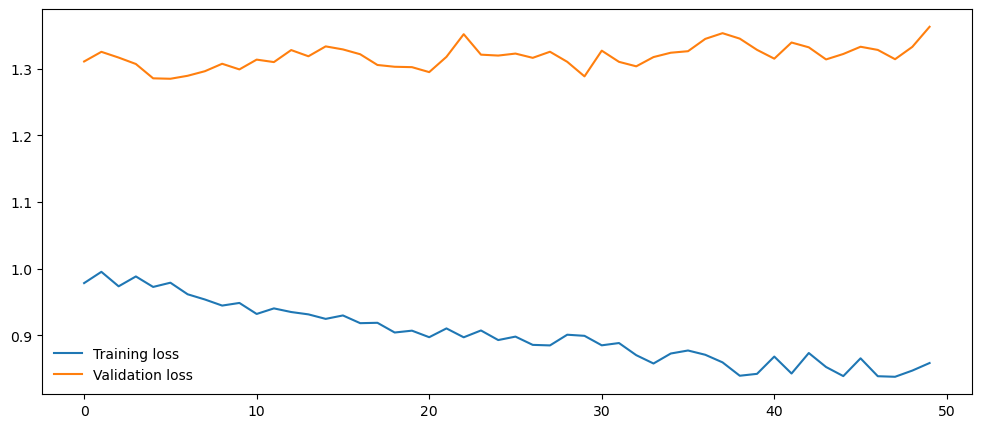

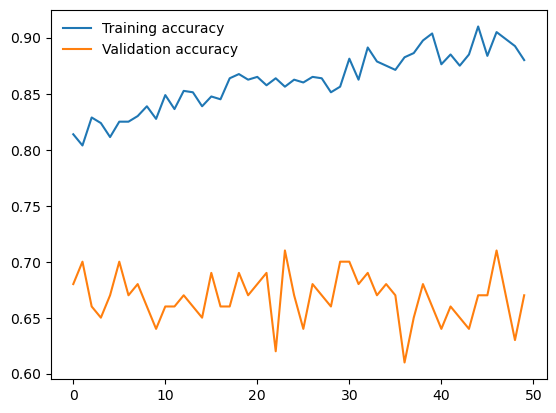

In [44]:
# Plotting
plt.figure(figsize=(12, 5))

plt.plot(train_losses, label='Training loss')
plt.plot(val_losses, label='Validation loss')
plt.legend(frameon=False)
plt.savefig('../Output/DeiT/deit_loss.png')
plt.show()

plt.plot(train_accuracies, label='Training accuracy')
plt.plot(val_accuracies, label='Validation accuracy')
plt.legend(frameon=False)
plt.savefig('../Output/DeiT/deit_accuracy.png')
plt.show()

In [46]:
test_loss = 0.0
class_correct = list(0 for i in range(len(classes)))
class_total = list(0 for i in range(len(classes)))
model_ft.eval()

for data, target in tqdm(test_loader):
    data, target = data.to(device), target.to(device)
    with torch.no_grad(): # turn off autograd for faster testing
        output = model_ft(data)
        loss = criterion(output, target)
    test_loss = loss.item() * data.size(0)
    _, pred = torch.max(output, 1)
    correct_tensor = pred.eq(target.data.view_as(pred))
    correct = np.squeeze(correct_tensor.cpu().numpy())
    if len(target) == 32:
        for i in range(32):
            label = target.data[i]
            class_correct[label] += correct[i].item()
            class_total[label] += 1

test_loss = test_loss / test_data_len
print('Test Loss: {:.4f}'.format(test_loss))
for i in range(len(classes)):
    if class_total[i] > 0:
        print("Test Accuracy of %5s: %2d%% (%2d/%2d)" % (
            classes[i], 100*class_correct[i]/class_total[i], np.sum(class_correct[i]), np.sum(class_total[i])
        ))
    else:
        print("Test accuracy of %5s: NA" % (classes[i]))
print("Test Accuracy of %2d%% (%2d/%2d)" % (
            100*np.sum(class_correct)/np.sum(class_total), np.sum(class_correct), np.sum(class_total)
        ))

100%|██████████| 4/4 [00:01<00:00,  2.49it/s]

Test Loss: 0.0279
Test Accuracy of blues: 50% ( 5/10)
Test Accuracy of classical: 100% (10/10)
Test Accuracy of country: 50% ( 5/10)
Test Accuracy of disco: 50% ( 5/10)
Test Accuracy of hiphop: 80% ( 8/10)
Test Accuracy of  jazz: 62% ( 5/ 8)
Test Accuracy of metal: 90% ( 9/10)
Test Accuracy of   pop: 66% ( 6/ 9)
Test Accuracy of reggae: 55% ( 5/ 9)
Test Accuracy of  rock: 50% ( 5/10)
Test Accuracy of 65% (63/96)
